# Notebook to compute the parameter M for the Klein-Gordon equation

Copyright 2022 Birgit Hillebrecht

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [1]:
import os 
import sys

import numpy as np

from fipy import Variable, FaceVariable, CellVariable, Grid1D, ExplicitDiffusionTerm, TransientTerm, DiffusionTerm, Viewer, ImplicitSourceTerm, GaussianNoiseVariable
from fipy.tools import numerix

# fix seed to assert reproducibility
numerix.random.seed(1)


### RefExample: Setup the mesh and the cell variables 

In [2]:
# mesh and cell variables
nx = 50
dx = 1.0
mesh = Grid1D(nx=nx, dx=dx)
phi = CellVariable(name="solution variable",
                    mesh=mesh,
                    value=0.)

# diffusion constant
D = 1.

# boundary conditions
valueleft = 1
valueright = 0
phi.constrain(valueright, mesh.facesRight)
phi.constrain(valueleft, mesh.facesLeft)

# set up differential equation
eqX = TransientTerm() == ExplicitDiffusionTerm(coeff=D)

In [3]:
timeStepDuration = 0.9 * dx**2 / (2 * D)
steps = 100

phiAnalytical = CellVariable(name="analytical value",
                              mesh=mesh)

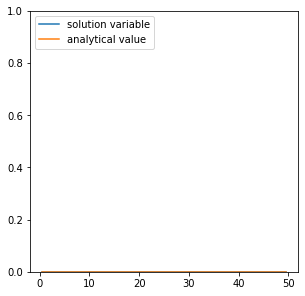

In [4]:
viewer = Viewer(vars=(phi, phiAnalytical),
                     datamin=0., datamax=1.)

In [5]:
x = mesh.cellCenters[0]
t = timeStepDuration * steps

In [6]:
try:
     from scipy.special import erf 
     phiAnalytical.setValue(1 - erf(x / (2 * numerix.sqrt(D * t)))) 
except ImportError:
    print("The SciPy library is not available to test the solution to \
    the transient diffusion equation")

### RefExample: Use FiPy to solve the equation for fixed timesteps

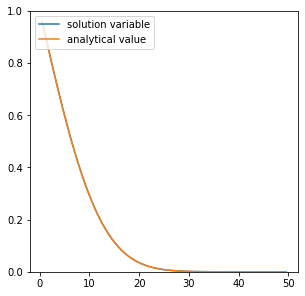

<Figure size 432x288 with 0 Axes>

In [7]:
from builtins import range
for step in range(steps):
    eqX.solve(var=phi,
        dt=timeStepDuration)
        
viewer.plot()

In [8]:
# verify accuracy
print(phi.allclose(phiAnalytical, atol = 7e-4)) 


True


## Klein Gordon Equation - Reuse Mesh

In [9]:
nx = 200
dx = 1.0 / nx
mesh = Grid1D(dx=dx, nx=nx)

u0 = np.cos(2*np.pi*np.linspace(0,1.0,200))
u_t0 =(0.5*np.cos(4*np.pi*np.linspace(0,1.0,200)))

phi = CellVariable(mesh=mesh, elementshape=(2,))
phi.setValue(np.concatenate([np.reshape(u0, (1, nx)), np.reshape(u_t0, (1, nx))], axis =0))


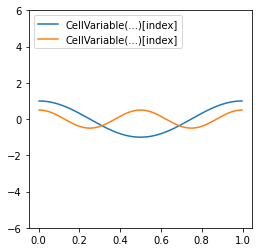

In [10]:
viewerphi = Viewer(vars=(phi[0,:], phi[1,:]),
                     datamin=-6., datamax=6.)

In [11]:
# Initialize the equation and M_max

eqKG = TransientTerm() == DiffusionTerm([((0.,  0.),
...                                                   (1.0, 0.))]) + \
...                                   ImplicitSourceTerm(((0.0, 1.0), 
...                                                       (-0.25, 0.0)))

M_max = 0

## Klein Gordon: Solve it for multiple gaussian noises

In [13]:
elapsed = 0.
duration = 0.5
counter = 0

# set starting conditions
starting_conditions = np.concatenate([np.reshape(u0, (1, nx)), np.reshape(u_t0, (1, nx))], axis =0)
phi.setValue(starting_conditions)

# get absolute value of starting conditions
absval_starting = np.sqrt(np.sum(np.square(starting_conditions), axis=0))
mag_start = (np.trapz(absval_starting, np.linspace(0,1.0, 200)))

while elapsed < duration:
     dt = 0.0001
     counter = counter+1
     elapsed += dt
     eqKG.solve(var=phi, dt=dt)
     if counter % 100 == 0:
          #viewerphi.plot()
          absval_now = np.sqrt(np.sum(np.square(phi.value), axis=0))
          mag_now = (np.trapz(absval_now, np.linspace(0,1.0, 200)))
          growth = mag_now / mag_start
          #print("t_elapsed = " + str(elapsed) + "; \t mag now = " + str(mag_now)+ "; \t M_LL = " + str(growth))
          if growth > M_max :
               M_max = growth


In [14]:
numerix.random.seed(1)
for index in range(0,20):
     print(index)
     elapsed = 0.
     duration = 0.5
     counter = 0

     # set starting conditions
     noise0 = GaussianNoiseVariable(mesh=mesh, mean=index, variance=0.05).value
     noise1 = GaussianNoiseVariable(mesh=mesh, mean=1, variance=0.05).value
     starting_conditions = np.concatenate([np.reshape(noise0, (1, nx)), np.reshape(noise1, (1, nx))], axis = 0)
     phi.setValue(starting_conditions)

     # get absolute value of starting conditions
     absval_starting = np.sqrt(np.sum(np.square(starting_conditions), axis=0))
     mag_start = (np.trapz(absval_starting, np.linspace(0,1.0, 200)))

     while elapsed < duration:
          dt = 0.0001
          counter = counter+1
          elapsed += dt
          eqKG.solve(var=phi, dt=dt)
          if counter % 100 == 0:
               #viewerphi.plot()
               absval_now = np.sqrt(np.sum(np.square(phi.value), axis=0))
               mag_now = (np.trapz(absval_now, np.linspace(0,1.0, 200)))
               growth = mag_now / mag_start
               #print("t_elapsed = " + str(elapsed) + "; \t mag now = " + str(mag_now)+ "; \t M_LL = " + str(growth))
               if growth > M_max :
                    M_max = growth
                    print("Update M_max: " + str(M_max))

0
Update M_max: 28.53827557679345
Update M_max: 39.265503666925405
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [15]:
numerix.random.seed(5468)
for index in range(0,20):
     print(index)
     elapsed = 0.
     duration = 0.5
     counter = 0

     # set starting conditions
     noise0 = GaussianNoiseVariable(mesh=mesh, mean=1, variance=0.05).value
     noise1 = GaussianNoiseVariable(mesh=mesh, mean=index, variance=0.1).value
     starting_conditions = np.concatenate([np.reshape(noise0, (1, nx)), np.reshape(noise1, (1, nx))], axis = 0)
     phi.setValue(starting_conditions)

     # get absolute value of starting conditions
     absval_starting = np.sqrt(np.sum(np.square(starting_conditions), axis=0))
     mag_start = (np.trapz(absval_starting, np.linspace(0,1.0, 200)))

     while elapsed < duration:
          dt = 0.0001
          counter = counter+1
          elapsed += dt
          eqKG.solve(var=phi, dt=dt)
          if counter % 100 == 0:
               #viewerphi.plot()
               absval_now = np.sqrt(np.sum(np.square(phi.value), axis=0))
               mag_now = (np.trapz(absval_now, np.linspace(0,1.0, 200)))
               growth = np.exp(-0*elapsed)*mag_now / mag_start
               #print("t_elapsed = " + str(elapsed) + "; \t mag now = " + str(mag_now)+ "; \t M_LL = " + str(growth))
               if growth > M_max :
                    M_max = growth
                    print("Update M_max: " + str(M_max))

0
Update M_max: 40.619428437646256
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [16]:
numerix.random.seed(7796)
for index in range(0,10):
     print(index)
     elapsed = 0.
     duration = 0.5
     counter = 0

     # set starting conditions
     noise0 = GaussianNoiseVariable(mesh=mesh, mean=1, variance=0.05).value
     noise1 = GaussianNoiseVariable(mesh=mesh, mean=0, variance=0.05*index).value
     starting_conditions = np.concatenate([np.reshape(noise0, (1, nx)), np.reshape(noise1, (1, nx))], axis = 0)
     phi.setValue(starting_conditions)

     # get absolute value of starting conditions
     absval_starting = np.sqrt(np.sum(np.square(starting_conditions), axis=0))
     mag_start = (np.trapz(absval_starting, np.linspace(0,1.0, 200)))

     while elapsed < duration:
          dt = 0.0001
          counter = counter+1
          elapsed += dt
          eqKG.solve(var=phi, dt=dt)
          if counter % 100 == 0:
               #viewerphi.plot()
               absval_now = np.sqrt(np.sum(np.square(phi.value), axis=0))
               mag_now = (np.trapz(absval_now, np.linspace(0,1.0, 200)))
               growth = np.exp(-0*elapsed)*mag_now / mag_start
               #print("t_elapsed = " + str(elapsed) + "; \t mag now = " + str(mag_now)+ "; \t M_LL = " + str(growth))
               if growth > M_max :
                    M_max = growth
                    print("Update M_max: " + str(M_max))

0
1
Update M_max: 42.02811030893212
2
3
4
5
6
7
8
9


In [17]:
numerix.random.seed(23135)
for index in range(0,20):
     print(index)
     elapsed = 0.
     duration = 0.5
     counter = 0

     # set starting conditions
     noise0 = GaussianNoiseVariable(mesh=mesh, mean=1, variance=0.05*index).value
     noise1 = GaussianNoiseVariable(mesh=mesh, mean=0, variance=0.05).value
     starting_conditions = np.concatenate([np.reshape(noise0, (1, nx)), np.reshape(noise1, (1, nx))], axis = 0)
     phi.setValue(starting_conditions)

     # get absolute value of starting conditions
     absval_starting = np.sqrt(np.sum(np.square(starting_conditions), axis=0))
     mag_start = (np.trapz(absval_starting, np.linspace(0,1.0, 200)))

     while elapsed < duration:
          dt = 0.0001
          counter = counter+1
          elapsed += dt
          eqKG.solve(var=phi, dt=dt)
          if counter % 100 == 0:
               #viewerphi.plot()
               absval_now = np.sqrt(np.sum(np.square(phi.value), axis=0))
               mag_now = (np.trapz(absval_now, np.linspace(0,1.0, 200)))
               growth = np.exp(-0.*elapsed)*mag_now / mag_start
               #print("t_elapsed = " + str(elapsed) + "; \t mag now = " + str(mag_now)+ "; \t M_LL = " + str(growth))
               if growth > M_max :
                    M_max = growth
                    print("Update M_max: " + str(M_max))

0
1
2
Update M_max: 55.69654118386088
3
Update M_max: 66.54036577126517
4
Update M_max: 89.12825680894099
5
6
Update M_max: 91.81104388965616
7
Update M_max: 107.40816096168179
8
9
Update M_max: 107.82697379367487
10
Update M_max: 118.04150008484825
11
12
13
Update M_max: 141.34334904906322
14
15
Update M_max: 164.43869916136964
16
17
18
19


## Estimated M_max

In [18]:
print(M_max)

164.43869916136964
